# SIPN South

This is a notebook attempting to generate outputs for [SIPN forecast](https://fmassonn.github.io/sipn-south.github.io/).

Relates to the following issue (private repo), [icenet-governance](https://github.com/icenet-ai/icenet-governance/issues/1).

Tasks (titled "**Diagnostic**") are ordered in priority, as defined within the call for contribution.

## Relevant terminology:

TODO
* SIC: Sea Ice Concentration
* SIA: Sea Ice Area
* SIE: Sea Ice Extent

## Imports

In [28]:
import logging
import os
from glob import glob

import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import plotly.express as px
import plotly.io as pio
import xarray as xr

from IPython.display import Image, HTML

In [2]:
from icenet.plotting.video import xarray_to_video as xvid
from icenet.data.sic.mask import Masks
from icenet.process.predict import get_prediction_data

## Loading prediction data

In [3]:
ds = xr.open_dataset("../pipeline/results/predict/sipn_test_0_south_forecast.nc")
land_mask = Masks(south=True, north=False).get_land_mask()

forecast_date = ds.time.values[0]
fc = ds.sic_mean.isel(time=0).drop_vars("time").rename(dict(leadtime="time"))
fc['time'] = [pd.to_datetime(forecast_date) \
              + dt.timedelta(days=int(e)) for e in fc.time.values]

anim = xvid(fc, 15, figsize=4, mask=land_mask)
HTML(anim.to_jshtml())

In [4]:
root = "../pipeline"
name = "sipn_test_0_south_forecast"
dates = [dt.date(*[2022, 11, 30])]

arr, ens_members = zip(*[get_prediction_data(root, name, date) for date in dates])
ens_members = list(ens_members)
# arr = np.array(arr)

print("Number of ensemble members:", ens_members)

Number of ensemble members: [10]


In [5]:
def get_prediction_data_nb(root: object, name: object, date: object) -> tuple:
    """
    Based on IceNet library v0.2.7.
    
    Ref:
    https://github.com/icenet-ai/icenet/blob/cb1cb785808ba1138c0ed0f8f88208a144daa6ff/icenet/process/predict.py#L63-L89
    """
    glob_str = os.path.join(root, "results", "predict", name, "*",
                            date.strftime("%Y_%m_%d.npy"))

    np_files = glob(glob_str)
    if not len(np_files):
        logging.warning("No files found")
        return None

    data = [np.load(f) for f in np_files]
    data = np.array(data)
    ens_members = data.shape[0]

    logging.debug("Data read from disk: {} from: {}".format(
        data.shape, np_files))

    return np.stack([data.mean(axis=0), data.std(axis=0)],
                    axis=-1).squeeze(), data, ens_members

In [6]:
arr, data, ens_members = get_prediction_data_nb(root, name, dates[0])

# Make sure we're only working with the 90 days needed for the SIPN South submission.
data = data[..., :90]

Do some checks of the data dimensions

In [7]:
data.shape

(10, 1, 432, 432, 90)

In [8]:
# Extract first forecast day
data[0][:, :, :, 0].squeeze().shape

(432, 432)

In [9]:
land_mask.shape

(432, 432)

Plot first forecast day with land masking applied

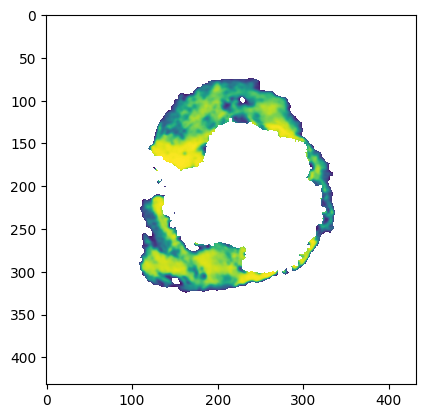

In [10]:
# Apply land masking
ds_masked = ma.array(data[0][:, :, :, 0].squeeze(), mask=land_mask)

# ds_masked = np.zeros_like(data[0][:, :, :, 0].squeeze())
# ds_masked[0] = 1
# ds_masked[1] = 1
# Apply marginal sea ice masking
ds_masked = ma.masked_where(ds_masked<0.15, ds_masked)
imgplot = plt.imshow(ds_masked)

In [11]:
# land_mask.shape[0] is 432
ds_masked_area = ds_masked.count() // land_mask.shape[0]
ds_masked_area
# imgplot = plt.imshow(ds_masked_area)

51

In [12]:
sea_ice_area = (np.sum(ds_masked) * ds_masked_area) / 1E6
sea_ice_area

0.7605800830078125

In [13]:
grid_cell_area = (25*25)/432

ice_covered_cells = ds_masked > 0.15

ice_covered_count = np.sum(ice_covered_cells)
print(ice_covered_count)

sea_ice_area = ice_covered_count * grid_cell_area

sea_ice_area

22350


32335.069444444445

In [14]:
def compute_sea_ice_area(sea_ice_concentration, mask=1, grid_cell_area=25*25, threshold=0.15, plot=False):
    sic = sea_ice_concentration.copy()

    # Mask values less than the threshold
    sic = ma.masked_where(sic<threshold, sic)
    
    # Mask land regions
    sic = ma.array(sic, mask=mask)
    
    if plot:
        sic_plot = plt.imshow(sic.squeeze())
    
    # Divide by 10^6 due to SIPN South unit requirement
    # (i.e., units must be in 10^6 km^2)
    sea_ice_area = np.sum( sic * grid_cell_area ) / 1E6

    return sea_ice_area

9.320834

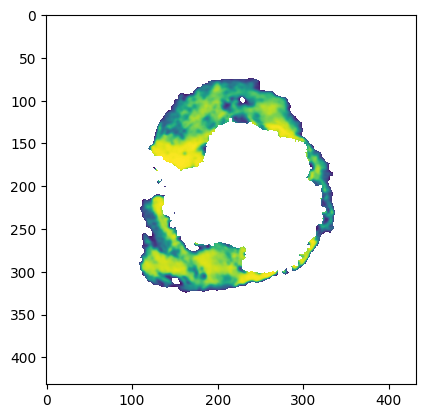

In [15]:
# Test masking with first ensemble member and first forecast day.
sea_ice_area = compute_sea_ice_area(data[0][:, :, :, 0], mask=land_mask, grid_cell_area=25*25, plot=True)
sea_ice_area

In [16]:
data[0][:, :, :, :].shape

(1, 432, 432, 90)

In [17]:
sea_ice_area = np.asarray([ compute_sea_ice_area(data[0][..., day], mask=land_mask) for day in range(data.shape[-1]) ])

In [18]:
sea_ice_area

array([9.320834  , 9.102515  , 9.181678  , 9.063554  , 8.847604  ,
       8.729337  , 8.724561  , 8.703206  , 8.710184  , 8.555348  ,
       8.569353  , 8.431687  , 8.1474015 , 8.05076   , 7.9272615 ,
       7.7364235 , 7.6266405 , 7.3686955 , 7.1834045 , 6.9104215 ,
       6.833844  , 6.610614  , 6.344951  , 6.2292705 , 6.0630565 ,
       5.9205835 , 5.7197925 , 5.65054   , 5.483069  , 5.3309005 ,
       5.167049  , 5.006303  , 4.966304  , 4.816771  , 4.6455865 ,
       4.6284905 , 4.522085  , 4.3495425 , 4.265445  , 4.191293  ,
       4.0420535 , 3.93539275, 3.86133775, 3.7497195 , 3.606944  ,
       3.535078  , 3.41611375, 3.314576  , 3.2201415 , 3.112681  ,
       2.995127  , 2.926501  , 2.840362  , 2.787431  , 2.700016  ,
       2.63016525, 2.5523505 , 2.44870475, 2.389213  , 2.335101  ,
       2.26612425, 2.2295085 , 2.192556  , 2.14300925, 2.10172225,
       2.06160013, 2.06438875, 2.01792887, 2.0350545 , 1.97697388,
       1.96824425, 1.95361075, 1.9684925 , 1.96624237, 1.97709

In [19]:
root

'../pipeline'

### Load truth SIA from OSI-SAF

In [20]:
# Load truth from OSI-SAF

year_files = [
    os.path.join(root, "data", "osisaf", "south", "siconca", "2022.nc"),
    os.path.join(root, "data", "osisaf", "south", "siconca", "2023.nc")
]

ds = xr.open_mfdataset(year_files, parallel=False)

ds.close()

In [21]:
ds

<xarray.Dataset>
Dimensions:   (xc: 432, yc: 432, time: 727)
Coordinates:
  * xc        (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc        (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
  * time      (time) datetime64[ns] 2022-01-01 2022-01-02 ... 2023-12-28
    lon       (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
    lat       (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
Data variables:
    ice_conc  (time, yc, xc) float64 dask.array<chunksize=(365, 432, 432), meta=np.ndarray>

In [22]:
start_date = "2022-12-01"
end_date = "2023-02-28"

osisaf_sic_subset = ds.sel(time=slice(start_date, end_date))

osisaf_sic_subset

<xarray.Dataset>
Dimensions:   (xc: 432, yc: 432, time: 90)
Coordinates:
  * xc        (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc        (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
  * time      (time) datetime64[ns] 2022-12-01 2022-12-02 ... 2023-02-28
    lon       (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
    lat       (yc, xc) float32 dask.array<chunksize=(432, 432), meta=np.ndarray>
Data variables:
    ice_conc  (time, yc, xc) float64 dask.array<chunksize=(31, 432, 432), meta=np.ndarray>

In [23]:
osisaf_sic_subset["ice_conc"].values.shape

(90, 432, 432)

In [24]:
test = osisaf_sic_subset["ice_conc"].values[0, ...]
test[test>0]

array([0.1371, 0.138 , 0.1384, ..., 0.1377, 0.1296, 0.0952])

In [25]:
sea_ice_area_osisaf = np.asarray([ compute_sea_ice_area(osisaf_sic_subset["ice_conc"].values[day, ...], mask=land_mask) for day in range(90) ])

In [26]:
sea_ice_area_osisaf

array([8.93071825, 8.67348706, 8.49877763, 8.31656194, 8.13787644,
       7.93044594, 7.71167106, 7.54854725, 7.26967737, 6.92075537,
       6.50779425, 6.26572806, 6.1199395 , 5.91762644, 5.65431387,
       5.51790031, 5.32410144, 5.08091806, 4.91020594, 4.766022  ,
       4.64724956, 4.48753675, 4.33639   , 4.17550994, 3.99680431,
       3.84106837, 3.73441987, 3.57112025, 3.36180225, 3.27105163,
       3.20735525, 3.11641206, 3.04447931, 2.94192081, 2.84270956,
       2.82169763, 2.767689  , 2.66589575, 2.57271875, 2.54843006,
       2.49037394, 2.46551488, 2.39264125, 2.31387056, 2.27571688,
       2.19727425, 2.16408244, 2.15743763, 2.09544   , 2.03818487,
       1.970588  , 1.91741919, 1.81596806, 1.75479369, 1.736203  ,
       1.64911312, 1.61254856, 1.60170606, 1.55852481, 1.5231465 ,
       1.50669881, 1.48284819, 1.47658869, 1.43981362, 1.41773587,
       1.405124  , 1.3887845 , 1.38531169, 1.34484125, 1.31922987,
       1.27258006, 1.22586081, 1.23656069, 1.24184238, 1.27614

In [42]:
data_plt = {
    "Time": pd.date_range(start=start_date, end=end_date),
    "icenet": sea_ice_area,
    "osisaf": sea_ice_area_osisaf
}

df_plt = pd.DataFrame(data_plt)

fig = px.line(
    df_plt,
    x="Time",
    y=["icenet", "osisaf"],
    labels={
        "value": "10<sup>6</sup> km<sup>2</sup>",
        "Time": "Time"
    },
    title="Dec-Jan-Feb 2022-2023 Antarctic Sea Ice Area (SIA)"
)

fig.update_xaxes(tickmode="linear", tick0=start_date, dtick=86400000*11)
fig.update_layout(xaxis_title=None, showlegend=True, legend_title_text="")

# # Convert to static image because notebook file size increases too much.
# Image(pio.to_image(fig, format="jpg"))

___
# Diagnosis

## Diagnostic 1:

<u>**Diagnostic:**</u> Antarctic (circumpolar) daily mean sea-ice area from December 1st 2022 to February 28th 2023 included (90 days).

<u>**Format:**</u> One text file with one row and 90 comma-separated values, each expressing daily sea-ice area for the 31 + 31 + 28 days of the December-February period. Units must be 10<sup>6</sup> km². Numbers must be rounded to four decimal digits and trailing zeroes must be included.

<u>**File name:**</u> `<group-name>_<forecast-id>_totalarea.txt`
  - `<group-name>` is the name of the participating group (university, research center, institution)
  - `<forecast-id>` is a 3-digit identifier for the forecast (001, 002, …)

<u>**Remarks:**</u> Ensemble forecasts are welcome. Please keep one file per forecast and increment each time the `<forecast-id>` by one unit: 001 for the first forecast, 002 for the second, etc. If only one forecast is submitted, set `<forecast-id>` to 001.

## Diagnostic 2:

<u>**Diagnostic:**</u> February Antarctic daily mean sea-ice area per 10° longitude bin, from December 1st 2022 to February 28th 2023 included (90 days).

<u>**Format:**</u> A text file with 36 rows each displaying 90 comma-separated values following the same requirements as diagnostic 1. Each row corresponds to a
10° longitude bin. First row: 0° <= longitude < 10°; second row: 10° <= longitude < 20°; …, 36th row: 350° <= longitude < 360°.

<u>**File name:**</u> `<group-name>_<forecast-id>_regional-area.txt`

<u>**Remarks:**</u> Ensemble forecasts are welcome. Please keep one file per forecast and increment each time the `<forecast-id>` by one unit: 001 for the first forecast, 002 for the second, etc. If only one forecast is submitted, set `<forecast-id>` to 001.

## Diagnostic 3:

<u>**Diagnostic:**</u> February Antarctic daily mean sea-ice concentration Format: A NetCDF file with 90 timesteps (one per day from December 1st 2022 to February 28th 2023). Each time step displays the spatial field of sea-ice concentration. The file format must follow the CMIP6 conventions:
  - Sea-ice concentration is defined as the fraction of the grid cell covered by sea ice, is named `siconc`, and is expressed in %.
  - Longitude and latitude are reported under variables `longitude` and `latitude`.
  - A land-sea mask is provided through a variable named `sftof` that expresses the percentage of the grid cell covered by ocean (units %).
  - Areas of grid cells are provided through a variable named `areacello` that expresses the area of the grid cell in m².

<u>**File name:**</u> `<group-name>_<forecast-id>_concentration.nc`

<u>**Remarks:**</u> Ensemble forecasts are welcome. Please keep one file per forecast and increment each time the `<forecast-id>` by one unit: 001 for the first forecast, 002 for the second, etc. If only one forecast is submitted, set `<forecast-id>` to 001.